In [1]:
import torch.nn as nn
import torch

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down else
            nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )
        
    def forward(self, x):
        return self.conv(x)

class Residual_block(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.main = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1)
        )
        
    def forward(self, x):
        return x + self.main(x)
    
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=6):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True)
        )
        
        self.down_blocks = nn.ModuleList([
            ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
            ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1)
        ])
        
        self.residual_blocks = nn.Sequential(
            *[Residual_block(num_features*4) for _ in range(num_residuals)]
        )
              
        self.up_blocks = nn.ModuleList([
            ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvBlock(num_features*2, num_features, down=False, kernel_size=3, stride=2, padding=1, output_padding=1)
        ])
        
        self.final = nn.Conv2d(num_features, img_channels, 7, 1, 3, padding_mode="reflect")
        
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.residual_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.final(x))
        
        
def test():
    gen = Generator(3, 64, 9)
    img = torch.randn(1, 3, 256, 256)
    output = gen(img)
    assert output.shape == img.shape
    print(f"Test case passed!")

test()

Test case passed!


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen_R = Generator(img_channels=3, num_residuals=9).to(device)
gen_P = Generator(img_channels=3, num_residuals=9).to(device)


gen_R.load_state_dict(torch.load("./paint_to_real3.pth"))
gen_P.load_state_dict(torch.load("./real_to_paint3.pth"))
gen_P.eval()
gen_R.eval()

device

device(type='cpu')

In [5]:
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from PIL import Image

data_transform = A.Compose([
    A.Resize(width=256, height=256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
    ToTensorV2()
], additional_targets={"image0":"image"})

data_transform2 = A.Compose([
    A.CenterCrop(height=256, width=256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
    ToTensorV2()
])



c:\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Python311\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


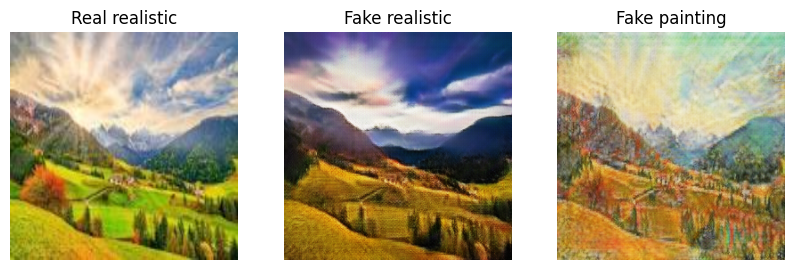

In [6]:
test_img = Image.open("./save.jpg").convert("RGB")

augmentations = data_transform(image=np.array(test_img))
img = augmentations["image"]

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow((img*0.5+0.5).permute(1, 2, 0))
plt.axis("off")
plt.title("Real realistic")

fake_real = (gen_R(img).detach()) * 0.5 + 0.5 
plt.subplot(1, 3, 2)
plt.imshow(fake_real.permute(1, 2, 0))
plt.axis("off")
plt.title("Fake realistic")

fake_paint = (gen_P(img).detach()) * 0.5 + 0.5
plt.subplot(1, 3, 3)
plt.imshow(fake_paint.permute(1, 2, 0))
plt.axis("off")
plt.title("Fake painting")

plt.show()